In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import beta, ttest_ind

In [ ]:
# load and clean data
def load_data(filepath):
    # load data from csv
    data = pd.read_csv(filepath)

    # select only the relevant columns, indicated by Angela
    relevant_data = data[['isInList', 'completed', 'breathe', 'policy_150', 'correct']]

    # remove the first two rows (unneeded header rows)
    relevant_data = relevant_data.drop([0, 1], axis=0)

    # filter out all data where isInList is false or completed is false and remove these columns
    relevant_data = relevant_data[(relevant_data['isInList'] == 'true') & (relevant_data['completed'] == 'true')]
    relevant_data = relevant_data.drop(['isInList', 'completed'], axis=1)

    # change breathe column from "yes"/"no" to 1/0
    relevant_data['breathe'] = (relevant_data['breathe'] == 'yes').astype(int)

    # make correct column int
    relevant_data['correct'] = (relevant_data['correct'] == '1').astype(int)

    # add policy name column
    relevant_data.loc[relevant_data['policy_150'] == '1', 'policy_name'] = 'UR'
    relevant_data.loc[relevant_data['policy_150'] == '3', 'policy_name'] = 'TS'
    relevant_data.loc[relevant_data['policy_150'] == '17', 'policy_name'] = 'TS-PD'

    relevant_data = relevant_data.rename(columns={'correct': 'reward', 'breathe': 'arm', 'policy_150': 'policy_code'})

    return relevant_data


In [ ]:
def summary_stats(data):
    reward = pd.DataFrame()

    beta_dist = pd.DataFrame()
    beta_dist['policy'] = ['UR', 'UR', 'TS', 'TS', 'TS-PD', 'TS-PD']
    beta_dist['arm'] = [0, 1, 0, 1, 0, 1]

    policy = ['UR', 'TS', 'TS-PD']

    for i in range(3):
        class_idx = (data['policy_name'] == policy[i])
        class_data = data[class_idx]
        N = len(class_data)

        # calculate total reward per policy
        reward.at[i, 'total_reward'] = class_data['reward'].sum()
        reward.at[i, 'num_observations'] = N
        reward.at[i, 'normalized_reward'] = class_data['reward'].sum()/N

        # calculate observed distributions per arm per policy
        for a in range(2):
            arm_idx = (class_data['arm'] == a)
            arm_data = class_data[arm_idx]
            N = len(arm_data)
            beta_dist.at[2*i+a, 'alpha'] = arm_data['reward'].sum()
            beta_dist.at[2*i+a, 'beta'] = N - arm_data['reward'].sum()
            beta_dist.at[2*i+a, 'mean'] = arm_data['reward'].sum() / N

    reward = reward.rename(index={0: 'UR', 1: 'TS', 2: 'TS-PD'})

    # also calculate reward per arm, regardless of policy
    arms = pd.DataFrame()
    for a in range(2):
        arm_idx = (data['arm'] == a)
        arm_data = data[arm_idx]
        N = len(arm_data)
        arms.at[a, 'total_reward'] = arm_data['reward'].sum()
        arms.at[a, 'num_observations'] = N
        arms.at[a, 'normalized_reward'] = arm_data['reward'].sum() / N

    return reward, beta_dist, arms

In [ ]:
def plot_beta(beta_dist):
    for i in range(3):
        ax = plt.subplot(3, 1, i + 1)
        ax.set_title(beta_dist.at[2*i, 'policy'])
        x = np.arange(0, 1, 0.01)
        distribution_arm1 = beta.pdf(x, beta_dist.at[2*i, 'alpha'], beta_dist.at[2*i, 'beta'])
        distribution_arm2 = beta.pdf(x, beta_dist.at[2*i+1, 'alpha'], beta_dist.at[2*i+1, 'beta'])
        ax.plot(x, distribution_arm1, label='no prompt')
        ax.plot(x, distribution_arm2, label='prompt')
        ax.tick_params(axis='both', labelsize=8)
        ax.legend()

    plt.subplots_adjust(hspace=0.5)
    plt.savefig('beta_dist.png')
    plt.show()

In [ ]:
def stat_sig_policy(data):
    policy = ['UR', 'TS', 'TS-PD']

    for i in range(3):
        class_idx = (data['policy_name'] == policy[i])
        class_data = data[class_idx]
        N = len(class_data)

        arm0_idx = (class_data['arm'] == 0)
        arm0_data = class_data[arm0_idx]
        arm1_idx = (class_data['arm'] == 1)
        arm1_data = class_data[arm1_idx]

        res = ttest_ind(arm0_data['reward'], arm1_data['reward'])
        print("policy: ", policy[i])
        print("statistical significance: ", res)


def stat_sig_overall(data):
    arm0_idx = (data['arm'] == 0)
    arm0_data = data[arm0_idx]
    arm1_idx = (data['arm'] == 1)
    arm1_data = data[arm1_idx]

    res = ttest_ind(arm0_data['reward'], arm1_data['reward'])
    print("statistical significance: ", res)

       total_reward  num_observations  normalized_reward
UR            118.0             556.0           0.212230
TS            116.0             508.0           0.228346
TS-PD         117.0             510.0           0.229412
   total_reward  num_observations  normalized_reward
0         171.0             793.0           0.215637
1         180.0             781.0           0.230474
  policy  arm  alpha   beta      mean
0     UR    0   59.0  205.0  0.223485
1     UR    1   59.0  233.0  0.202055
2     TS    0   63.0  194.0  0.245136
3     TS    1   53.0  198.0  0.211155
4  TS-PD    0   49.0  223.0  0.180147
5  TS-PD    1   68.0  170.0  0.285714


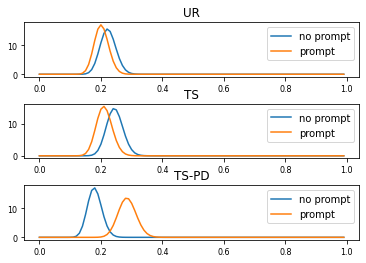

policy:  UR
statistical significance:  Ttest_indResult(statistic=0.6162291943652656, pvalue=0.5379963755360742)
policy:  TS
statistical significance:  Ttest_indResult(statistic=0.911163574947898, pvalue=0.36264305206628744)
policy:  TS-PD
statistical significance:  Ttest_indResult(statistic=-2.845632204069852, pvalue=0.004611390573508127)
statistical significance:  Ttest_indResult(statistic=-0.7066992032221676, pvalue=0.47985815823884304)


In [ ]:
# load and clean data
data = load_data('data.csv')

# calculate overall mean and per arm beta distributions, per policy
reward, beta_dist, arms = summary_stats(data)
print(reward)
print(arms)
print(beta_dist)

# plot beta distributions
plot_beta(beta_dist)

# calculate the statistical significance of the mean estimates for each arm per policy
stat_sig_policy(data)
stat_sig_overall(data)